# Scenario 3: Causal Reasoning with Interventions

### Load dependencies

In [1]:
import os
import json
import sympy
import pandas as pd
import pyciemss
import torch
import pyro
import pyro.distributions as dist

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

from mira.metamodel import *
from mira.examples.concepts import susceptible, exposed, infected, recovered
from mira.modeling import Model
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.metamodel.io import model_to_json_file, model_from_json_file
from pathlib import Path

## Simulate SEIR model

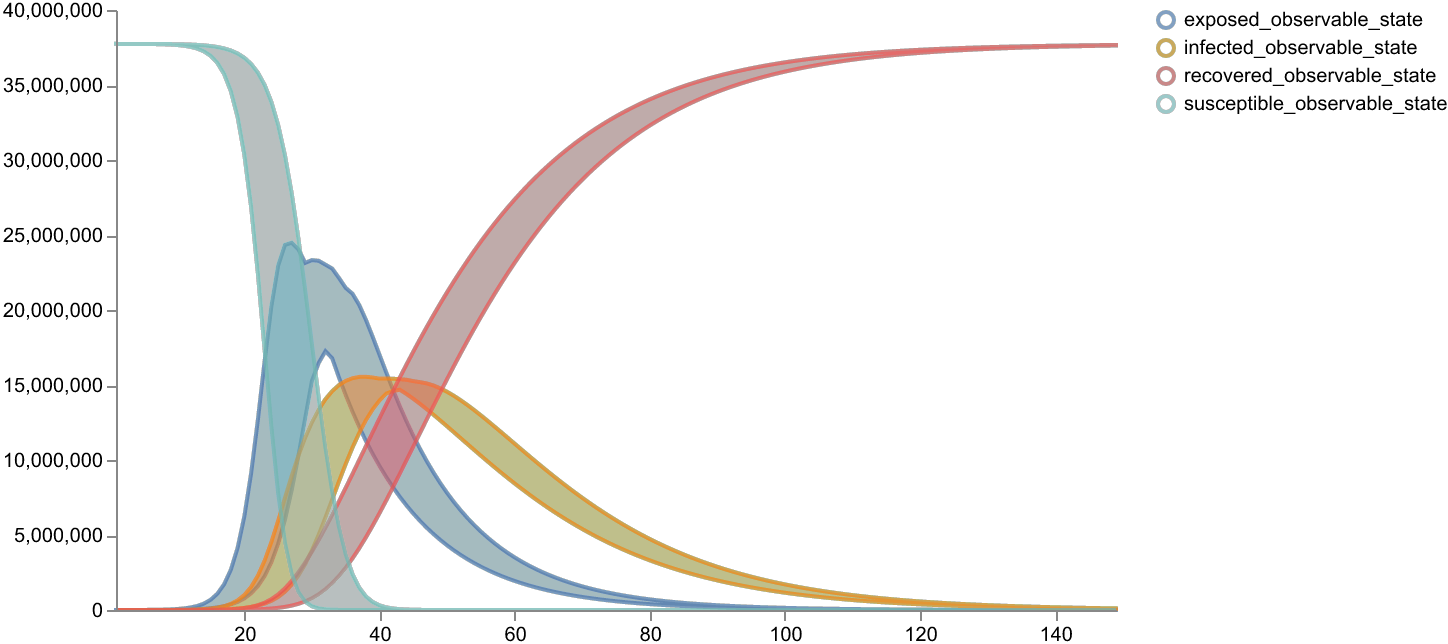

In [2]:
model1 = "SEIR_model.json"
start_time = 0.0
end_time = 150.0
logging_step_size = 1.0
num_samples = 10

result1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time,
                          solver_method="rk4", solver_options={"step_size": 1.})
# display(result1['data'].head())

# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*observable_state")
# plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Define interventions at `t = 20, 50, 80, 100`

In [3]:
social_dist = [0.3, 0.8]
intervention_dict = {torch.tensor(20.0): {"Myy": torch.tensor(social_dist[0]*38.62), 
                                          "Mym": torch.tensor(social_dist[0]*20.56),
                                          "Myo": torch.tensor(social_dist[0]*6.12),
                                          "Mmy": torch.tensor(social_dist[0]*20.56),
                                          "Mmm": torch.tensor(social_dist[0]*28.22),
                                          "Mmo": torch.tensor(social_dist[0]*11.6),
                                          "Moy": torch.tensor(social_dist[0]*6.12),
                                          "Mom": torch.tensor(social_dist[0]*11.6),
                                          "Moo": torch.tensor(social_dist[0]*20.01)
                                         },
                     torch.tensor(50.0): {"mcw": torch.tensor(0.5), 
                                          "mew": torch.tensor(0.6)
                                         },
                     torch.tensor(80.0): {"Myy": torch.tensor(social_dist[1]*38.62), 
                                          "Mym": torch.tensor(social_dist[1]*20.56),
                                          "Myo": torch.tensor(social_dist[1]*6.12),
                                          "Mmy": torch.tensor(social_dist[1]*20.56),
                                          "Mmm": torch.tensor(social_dist[1]*28.22),
                                          "Mmo": torch.tensor(social_dist[1]*11.6),
                                          "Moy": torch.tensor(social_dist[1]*6.12),
                                          "Mom": torch.tensor(social_dist[1]*11.6),
                                          "Moo": torch.tensor(social_dist[1]*20.01)
                                         },
                     torch.tensor(100.0): {"mcw": torch.tensor(0.4), 
                                          "mew": torch.tensor(0.2)
                                         }
                    }
intervention_dict

{tensor(20.): {'Myy': tensor(11.5860),
  'Mym': tensor(6.1680),
  'Myo': tensor(1.8360),
  'Mmy': tensor(6.1680),
  'Mmm': tensor(8.4660),
  'Mmo': tensor(3.4800),
  'Moy': tensor(1.8360),
  'Mom': tensor(3.4800),
  'Moo': tensor(6.0030)},
 tensor(50.): {'mcw': tensor(0.5000), 'mew': tensor(0.6000)},
 tensor(80.): {'Myy': tensor(30.8960),
  'Mym': tensor(16.4480),
  'Myo': tensor(4.8960),
  'Mmy': tensor(16.4480),
  'Mmm': tensor(22.5760),
  'Mmo': tensor(9.2800),
  'Moy': tensor(4.8960),
  'Mom': tensor(9.2800),
  'Moo': tensor(16.0080)},
 tensor(100.): {'mcw': tensor(0.4000), 'mew': tensor(0.2000)}}

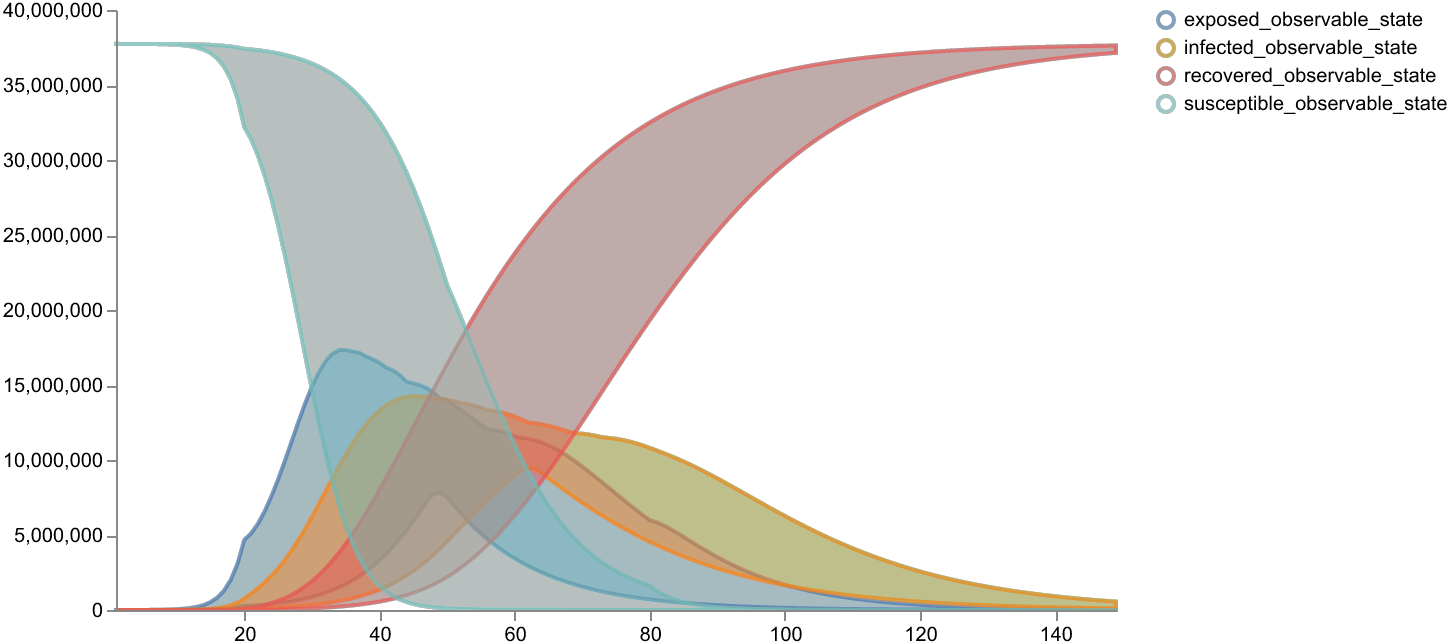

In [4]:
result = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time, 
                         static_parameter_interventions=intervention_dict,
                         solver_method="rk4", solver_options={"step_size": 1.})
# display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*observable_state")
# plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Calibrate the model 

In [18]:
dataset_20 = pd.read_csv("data_cut_at_20.csv")
display(dataset_20)
dataset_20 = dataset_20.drop(
    ["run", "R1", "R2", "R3", "S1", "S2", "S3", "E1", "E2", "E3"], axis=1
)
display(dataset_20)

,Timestamp,S1,S2,S3,E1,E2,E3,I1,I2,I3,R1,R2,R3,run
0,0,1.030566e+07,1.528190e+07,1.215444e+07,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,0.000000,0.000000,0.000000,13.0
1,1,1.030555e+07,1.528175e+07,1.215437e+07,151.794655,191.093779,117.866751,54.941877,56.474173,53.622694,3.109141,3.139898,3.082692,13.0
2,2,1.030542e+07,1.528158e+07,1.215428e+07,265.434124,348.890643,192.267918,67.851795,74.023679,62.493990,6.751479,6.997135,6.539158,13.0
3,3,1.030525e+07,1.528134e+07,1.215417e+07,408.748897,548.398327,283.652306,89.876683,104.270136,77.221285,11.432738,12.275393,10.698553,13.0
4,4,1.030502e+07,1.528102e+07,1.215402e+07,602.298709,818.417850,403.948286,123.568640,150.803945,99.234839,17.768941,19.833785,15.950812,13.0
5,5,1.030469e+07,1.528056e+07,1.215382e+07,872.518698,1195.937454,568.347068,173.136310,219.533582,130.923536,26.577081,30.813815,22.799430,13.0
6,6,1.030422e+07,1.527991e+07,1.215354e+07,1255.452081,1731.340828,797.409614,244.945417,319.382809,175.911931,38.988190,46.797501,31.926528,13.0
7,7,1.030355e+07,1.527898e+07,1.215314e+07,1801.627404,2495.207550,1119.810880,348.321181,463.408976,239.507686,56.599139,70.019486,44.279466,13.0
8,8,1.030260e+07,1.527764e+07,1.215258e+07,2582.755648,3587.646756,1576.100818,496.748783,670.476206,329.372924,81.683897,103.661998,61.190656,13.0
9,9,1.030123e+07,1.527573e+07,1.215178e+07,3701.143892,5151.413459,2223.986274,709.624122,967.695366,456.504595,117.492442,152.271990,84.546445,13.0


,Timestamp,I1,I2,I3
0,0,50.000000,50.000000,50.000000
1,1,54.941877,56.474173,53.622694
2,2,67.851795,74.023679,62.493990
3,3,89.876683,104.270136,77.221285
4,4,123.568640,150.803945,99.234839
5,5,173.136310,219.533582,130.923536
6,6,244.945417,319.382809,175.911931
7,7,348.321181,463.408976,239.507686
8,8,496.748783,670.476206,329.372924
9,9,709.624122,967.695366,456.504595


In [19]:
num_iterations = 100
dataset_20 = pd.read_csv("data_cut_at_20.csv")
dataset_20 = dataset_20.drop(
    ["run", "R1", "R2", "R3", "S1", "S2", "S3", "E1", "E2", "E3"], axis=1
)

data_mapping = {"I1": "I_y", "I2": "I_m", "I3": "I_o"}
# %time
calibrated_results = pyciemss.calibrate(
    model1,
    dataset_20,
    data_mapping=data_mapping,
    num_iterations=num_iterations,
    solver_method="rk4",
    solver_options={"step_size": 1.0},
)

parameter_estimates = calibrated_results["inferred_parameters"]
parameter_estimates()

C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\integration_utils\observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 20 rows of data. The first column, Timestamp, begins at 0 and ends at 20. The subsequent columns are named: I1, I2, I3


{'persistent_Myy': tensor(38.6467, grad_fn=<ExpandBackward0>),
 'persistent_beta': tensor(0.1184, grad_fn=<ExpandBackward0>),
 'persistent_mcw': tensor(0.0004, grad_fn=<ExpandBackward0>),
 'persistent_mew': tensor(0.0007, grad_fn=<ExpandBackward0>),
 'persistent_Mym': tensor(20.5634, grad_fn=<ExpandBackward0>),
 'persistent_Myo': tensor(6.1251, grad_fn=<ExpandBackward0>),
 'persistent_Mmy': tensor(20.5769, grad_fn=<ExpandBackward0>),
 'persistent_Mmm': tensor(28.2310, grad_fn=<ExpandBackward0>),
 'persistent_Mmo': tensor(11.6109, grad_fn=<ExpandBackward0>),
 'persistent_Moy': tensor(6.1252, grad_fn=<ExpandBackward0>),
 'persistent_Mom': tensor(11.6051, grad_fn=<ExpandBackward0>),
 'persistent_Moo': tensor(20.0177, grad_fn=<ExpandBackward0>)}